[pykrx](https://github.com/sharebook-kr/pykrx)

In [11]:
# 1. Library 호출
from pykrx import stock                     # 주가정보 호출 라이브러리
from scipy.stats.mstats import winsorize    # 전처리 : 이상치처리
import scipy.stats as ss                    # 전처리 : 정규화
import time                                 # 호출 1초 지연 -> API 차단 방지
import plotly.express as px                 # 시각화
import plotly.graph_objects as go           # 시각화
from plotly.subplots import make_subplots 
import matplotlib.pyplot as plt  # 시각화

import pandas as pd
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# 스타일 배분

## 가치점수
1. E/P
2. B/P

In [2]:
fm = stock.get_market_fundamental('20240603',market="KOSPI")
fm['E/P'] = (1/fm['PER']) # 역수 취하기
fm['B/P'] = (1/fm['PBR'])
fm = fm.query('PER != 0').sort_values('PER') # 결측값 제거

# E/P 구하기
ep = pd.DataFrame({'E/P':fm['E/P'].sort_values(ascending=False)})
ep['winE/P'] = winsorize(ep['E/P'],limits=[0.05,0.05])  # 이상치 조절
ep['stE/P'] = ss.zscore(ep['winE/P']) # z-score

# B/P 구하기
bp  = pd.DataFrame({'B/P':fm['B/P'].sort_values(ascending=False)})
bp['winB/P'] = winsorize(bp['B/P'],limits=[0.05,0.05])
bp['stB/P'] = ss.zscore(bp['winB/P'])

# 가치점수(VS) 만들기
value_S = pd.merge(ep,bp,left_index=True,right_index=True,how='inner')
value_S['VS'] = (value_S.iloc[:,2]+value_S.iloc[:,5])/2
value_S.sort_values(by='VS',ascending=False)

,E/P,winE/P,stE/P,B/P,winB/P,stB/P,VS
티커,,,,,,,
004960,0.403226,0.335570,2.311946,10.000000,4.347826,2.252019,2.281983
088350,0.338983,0.335570,2.311946,6.250000,4.347826,2.252019,2.281983
000540,1.204819,0.335570,2.311946,5.555556,4.347826,2.252019,2.281983
001230,0.534759,0.335570,2.311946,6.250000,4.347826,2.252019,2.281983
004690,0.367647,0.335570,2.311946,4.545455,4.347826,2.252019,2.281983
...,...,...,...,...,...,...,...
005070,0.005631,0.007657,-1.235021,0.096339,0.284091,-1.312532,-1.273776
009420,0.002081,0.007657,-1.235021,0.110742,0.284091,-1.312532,-1.273776
003670,0.001455,0.007657,-1.235021,0.119048,0.284091,-1.312532,-1.273776


## 성장점수
1. 12-month momentum
2. P/(3-year EPS NetChange)

In [3]:
# 1. 12개월 모멘텀
# 상장된 기업의 종가만 사용
close24 = pd.DataFrame({'24':stock.get_market_ohlcv('20240603',market="KOSPI")['종가']})
close21 = pd.DataFrame({'23':stock.get_market_ohlcv('20230601',market="KOSPI")['종가']})
ks = pd.merge(close21,close24,left_index=True,right_index=True,how='inner')

# 모멘텀 계산  
ks['Momentum'] =((ks['24']-ks['23'])/ks['23'])*100
ks.rename(columns={'23':'매수가','24':'매도가'},inplace=True)
ks['win_MM'] = winsorize(ks['Momentum'],limits=[0.05,0.05])
ks['stn_MM'] = ss.zscore(ks['win_MM'])

# 2. PEG 역수 구하긴
# 3년 EPS 증가율 구하기
df_21 = pd.DataFrame(stock.get_market_fundamental('2021-06-01',market="KOSPI")['EPS'])
df_21.rename(columns={'EPS':'EPS_21'},inplace=True)
df_24 = pd.DataFrame(stock.get_market_fundamental('2024-06-03',market="KOSPI")['EPS'])
df_24.rename(columns={'EPS':'EPS_24'},inplace=True)
eps = pd.merge(df_21,df_24,left_index=True,right_index=True,how='inner')
eps['NetChange'] = eps['EPS_24']-eps['EPS_21']

# 3년 EPS 증가율 대비 주가 (대략 PEG 개념)
eps = pd.merge(eps,close24,left_index=True,right_index=True,how='inner')
eps['approxPEG'] = (eps['NetChange']/eps['24'])
eps['win_P'] = winsorize(eps['approxPEG'],limits=[0.05,0.05])
eps.loc[eps['NetChange']==0,'win_P'] = 0 # 정규화하기 전에 필요
eps['stn_P'] = ss.zscore(eps['win_P'])

# 성장점수(GS) 만들기
growth_S = pd.merge(ks['stn_MM'],eps['stn_P'],left_index=True,right_index=True,how='inner')
growth_S['GS'] = (growth_S.iloc[:,0] + growth_S.iloc[:,1])/2
growth_S.sort_values('GS',ascending=False)

,stn_MM,stn_P,GS
티커,,,
003560,2.489346,1.831767,2.160557
071320,2.489346,1.831767,2.160557
000400,2.489346,1.831767,2.160557
101140,2.489346,1.831767,2.160557
005430,2.489346,1.318675,1.904011
...,...,...,...
005320,-1.517520,-2.735899,-2.126709
363280,-1.517520,-2.735899,-2.126709
002410,-1.517520,-2.735899,-2.126709


## 최종 순위 

In [4]:
# 데이터 합치기
style = pd.merge(value_S['VS'],growth_S['GS'],left_index=True,right_index=True,how='inner')
style= style.sort_values('GS',ascending=False)

In [5]:
# 성장 점수 순위 컬럼 생성
style['GS_Rank'] = style['GS'].rank(method='min',ascending=False)

# 가치 점수 순위 컬럼 생성
style['VS_Rank'] = style['VS'].rank(method='min',ascending=False)
# style.sort_values(by='VS_Rank')

# 스타일 순위 매기기 
# style['Rank'] = style.iloc[:,2]/style.iloc[:,3]
style['Rank'] = style['GS_Rank']/style['VS_Rank']
# style.sort_values(by='Rank')

In [6]:
style

,VS,GS,GS_Rank,VS_Rank,Rank
티커,,,,,
071320,2.061959,2.160557,1.0,11.0,0.090909
101140,0.541027,2.160557,1.0,153.0,0.006536
003560,0.636170,2.160557,1.0,142.0,0.007042
000400,0.804224,2.160557,1.0,121.0,0.008264
005430,0.084019,1.904011,5.0,229.0,0.021834
...,...,...,...,...,...
017390,0.951710,-1.855579,558.0,98.0,5.693878
003070,-0.069341,-1.912584,559.0,271.0,2.062731
001390,1.187111,-2.126709,560.0,73.0,7.671233


In [7]:
# 시가총액 불러오기
cap = pd.DataFrame(stock.get_market_cap('20240603',market="KOSPI")['시가총액'])
style_dt= pd.merge(style,cap,left_index=True,right_index=True,how='inner')
total_cap = style_dt.시가총액.sum()
total_cap

1636347034068428

In [8]:
# 전체 시총 대비 개별 종목 시총 비율 구하기
style_dt['cap_ratio'] = style_dt.iloc[:,5]/total_cap

# 개별 종목 시총 누적비율 컬럼 생성
style_dt=style_dt.sort_values(by='Rank')
style_dt['cum_cap'] = style_dt['cap_ratio'].cumsum()

# 시총 비율로 3구간 나눠서 성장,중간,가치 그룹화 하기
GS = style_dt[style_dt['cum_cap'] <= 0.33]
GS['group'] = 'growth'

NEUTRAL = style_dt[(style_dt['cum_cap'] > 0.33) & (style_dt['cum_cap'] <= 0.67)]
NEUTRAL['group'] = 'neutral'

VS = style_dt[style_dt['cum_cap']>0.67]
VS['group'] = 'value'

style_group = pd.concat([GS,NEUTRAL,VS],axis=0)
style_group

,VS,GS,GS_Rank,VS_Rank,Rank,시가총액,cap_ratio,cum_cap,group
티커,,,,,,,,,
101140,0.541027,2.160557,1.0,153.0,0.006536,93812977440,0.000057,0.000057,growth
003560,0.636170,2.160557,1.0,142.0,0.007042,59719334240,0.000036,0.000094,growth
000400,0.804224,2.160557,1.0,121.0,0.008264,968249318400,0.000592,0.000686,growth
005430,0.084019,1.904011,5.0,229.0,0.021834,218478495000,0.000134,0.000819,growth
035150,-0.425201,1.830221,8.0,362.0,0.022099,306204000000,0.000187,0.001006,growth
...,...,...,...,...,...,...,...,...,...
001130,2.281983,0.899620,88.0,1.0,88.000000,232037000000,0.000142,0.999475,value
004690,2.281983,0.547708,164.0,1.0,164.000000,386849385000,0.000236,0.999712,value
001230,2.281983,0.491172,184.0,1.0,184.000000,267124057200,0.000163,0.999875,value


In [9]:
# 나눈 구간으로 실제 시총 비율 확인하기 
growth_cap = style_group.groupby('group').get_group('growth').sum().시가총액
neutral_cap = style_group.groupby('group').get_group('neutral').sum().시가총액
value_cap = style_group.groupby('group').get_group('value').sum().시가총액

print((growth_cap/total_cap)*100)
print((neutral_cap/total_cap)*100)
print((value_cap/total_cap)*100)

# 스타일별 종목 개수 확인
print('\n',style_group.group.value_counts())

31.633205801881942
35.36428009359327
33.002514104524785

 group
value      393
growth     153
neutral     16
Name: count, dtype: int64


In [33]:
GS

,VS,GS,GS_Rank,VS_Rank,Rank,시가총액,cap_ratio,cum_cap,group
티커,,,,,,,,,
101140,0.541027,2.160557,1.0,153.0,0.006536,93812977440,0.000057,0.000057,growth
003560,0.636170,2.160557,1.0,142.0,0.007042,59719334240,0.000036,0.000094,growth
000400,0.804224,2.160557,1.0,121.0,0.008264,968249318400,0.000592,0.000686,growth
005430,0.084019,1.904011,5.0,229.0,0.021834,218478495000,0.000134,0.000819,growth
035150,-0.425201,1.830221,8.0,362.0,0.022099,306204000000,0.000187,0.001006,growth
...,...,...,...,...,...,...,...,...,...
028100,-0.634058,0.259384,261.0,415.0,0.628916,198844940900,0.000122,0.312643,growth
005300,-0.257152,0.467008,200.0,318.0,0.628931,1199759701200,0.000733,0.313376,growth
267270,-0.048335,0.538722,166.0,261.0,0.636015,1074284472000,0.000657,0.314032,growth


In [34]:
NEUTRAL

,VS,GS,GS_Rank,VS_Rank,Rank,시가총액,cap_ratio,cum_cap,group
티커,,,,,,,,,
068270,-1.125027,0.031223,346.0,530.0,0.652830,38841786917000,0.023737,0.340069,neutral
163560,-0.141874,0.478844,192.0,291.0,0.659794,113980000000,0.000070,0.340139,neutral
108670,0.169700,0.631155,143.0,216.0,0.662037,391438795500,0.000239,0.340378,neutral
030200,-0.055136,0.527004,175.0,264.0,0.662879,9579395691250,0.005854,0.346232,neutral
207940,-1.228515,-0.028787,366.0,551.0,0.664247,53522848000000,0.032709,0.378941,neutral
006110,-1.273776,-0.041868,375.0,558.0,0.672043,1207848303600,0.000738,0.379679,neutral
009150,-0.962896,0.047694,337.0,490.0,0.687755,11883767033600,0.007262,0.386941,neutral
086280,-0.144537,0.457097,201.0,292.0,0.688356,7053750000000,0.004311,0.391252,neutral
192650,-1.019525,0.015973,349.0,504.0,0.692460,632937006780,0.000387,0.391639,neutral


In [13]:
# 단일 산점도 그래프 (팝업 인덱스 표시)
fig = px.scatter(style, x='GS', y='VS',
                 title='Growth Score vs Value Score',
                 labels={'GS': 'Growth Score', 'VS': 'Value Score'},
                 color_discrete_sequence=['mediumpurple'],
                 hover_name=style.index)

fig.update_layout(
    xaxis_title='Growth Score',
    yaxis_title='Value Score',
    width=800,
    height=600
)

fig.show()


In [27]:
# 서브플롯을 사용하여 3개의 그래프를 하나로 합치기 (팝업 인덱스 표시, 범례 제거)
fig = make_subplots(rows=1, cols=3, subplot_titles=('Growth Group', 'Neutral Group', 'Value Group'))

# Growth Group
fig.add_trace(go.Scatter(x=GS['GS'], y=GS['VS'], mode='markers', 
                         marker=dict(color='red', size=8),
                         hovertext=GS.index, name='Growth Group',showlegend=False), row=1, col=1)

# Neutral Group
fig.add_trace(go.Scatter(x=NEUTRAL['GS'], y=NEUTRAL['VS'], mode='markers', 
                         marker=dict(color='gray', size=8),
                         hovertext=NEUTRAL.index, name='Neutral Group',showlegend=False), row=1, col=2)

# Value Group
fig.add_trace(go.Scatter(x=VS['GS'], y=VS['VS'], mode='markers', 
                         marker=dict(color='blue', size=8),
                         hovertext=VS.index, name='Value Group',showlegend=False), row=1, col=3)

# 레이아웃 업데이트

# 레이아웃 업데이트
fig.update_layout(
    xaxis=dict(range=[-1.0, 2.0]),
    yaxis=dict(range=[-1.0, 2.0]),
    # width=1600,
    # height=600
)

fig.update_xaxes(title_text="Growth Score", row=1, col=1)
fig.update_yaxes(title_text="Value Score", row=1, col=1)

fig.update_xaxes(title_text="Growth Score", row=1, col=2)
fig.update_yaxes(title_text="Value Score", row=1, col=2)

fig.update_xaxes(title_text="Growth Score", row=1, col=3)
fig.update_yaxes(title_text="Value Score", row=1, col=3)

fig.show()


In [10]:
# 하나의 산점도 그래프로 그룹별 데이터 표시
fig = go.Figure()

# Growth Group
fig.add_trace(go.Scatter(x=GS['GS'], y=GS['VS'], mode='markers', 
                         marker=dict(color='red', size=8),
                         hovertext=GS.index, name='Growth Group'))

# Neutral Group
fig.add_trace(go.Scatter(x=NEUTRAL['GS'], y=NEUTRAL['VS'], mode='markers', 
                         marker=dict(color='gray', size=8),
                         hovertext=NEUTRAL.index, name='Neutral Group'))

# Value Group
fig.add_trace(go.Scatter(x=VS['GS'], y=VS['VS'], mode='markers', 
                         marker=dict(color='blue', size=8),
                         hovertext=VS.index, name='Value Group'))

# 레이아웃 업데이트
fig.update_layout(
    title='Style Classification Result',
    xaxis_title='Growth Score',
    yaxis_title='Value Score',
    xaxis=dict(range=[-1.0, 2.0]),
    yaxis=dict(range=[-1.0, 2.0]),
    width=800,
    height=600
)
fig.write_html("style_result.html")
fig.show()


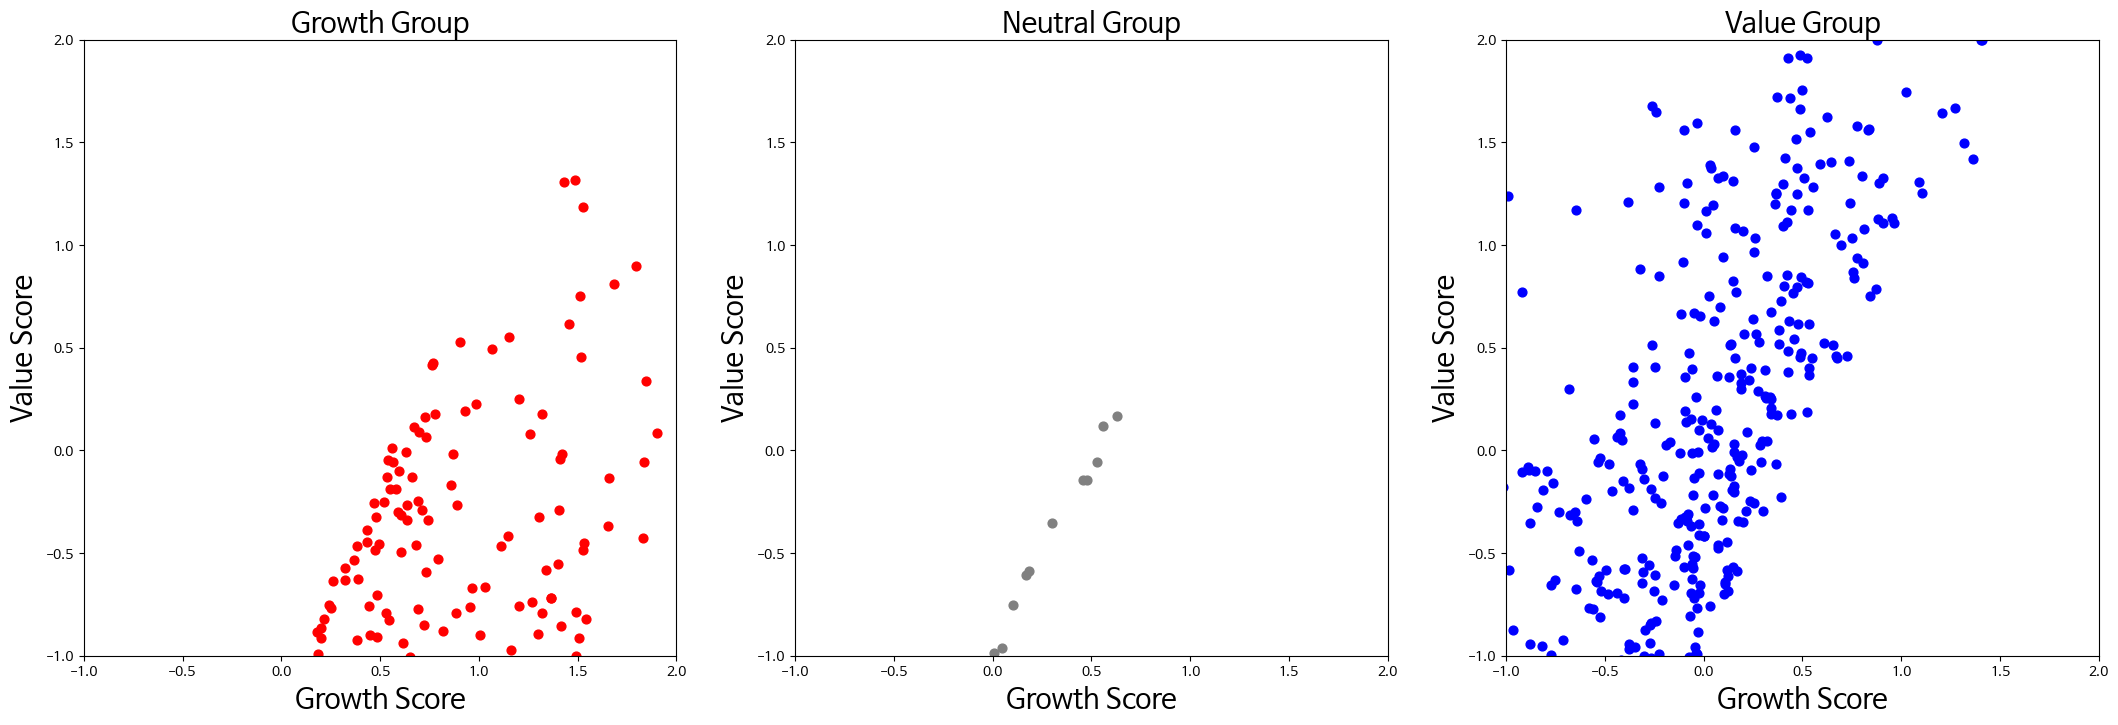

In [12]:
# 성장, 중립, 가치 그룹별 분포 확인

plt.figure(figsize=(26,8))

plt.subplot(1,3,1)
plt.scatter(GS['GS'],GS['VS'],s=40,c='red')
plt.title('Growth Group',size=20)
plt.xlabel('Growth Score',size=20)
plt.ylabel('Value Score',size=20)
plt.xlim([-1.0,2.0])
plt.ylim([-1.0,2.0])

plt.subplot(1,3,2)
plt.scatter(NEUTRAL['GS'],NEUTRAL['VS'],s=40,c='gray')
plt.title('Neutral Group',size=20)
plt.xlabel('Growth Score',size=20)
plt.ylabel('Value Score',size=20)
plt.xlim([-1.0,2.0])
plt.ylim([-1.0,2.0])

plt.subplot(1,3,3)
plt.scatter(VS['GS'],VS['VS'],s=40,c='blue')
plt.title('Value Group',size=20)
plt.xlabel('Growth Score',size=20)
plt.ylabel('Value Score',size=20)
plt.xlim([-1.0,2.0])
plt.ylim([-1.0,2.0])
plt.show()

## Nuetral 종목 구분하기 

1. AV, AG 계산

In [12]:
n = NEUTRAL

print(f'AV_G :{VS.GS.mean()}')
print(f'AV_V :{VS.VS.mean()}')
print(f'AG_G :{GS.GS.mean()}')
print(f'AG_V :{GS.VS.mean()}')

AV_G :-0.09683188730398012
AV_V :0.2589608805872862
AG_G :0.9230853249666636
AG_V :-0.4840451009196985


2. Neutral Group Midpoint Distance  

In [13]:
# if 에 해당
g_first = n[n['GS']>=GS.GS.mean()]
g_first['D(G,X)'] = abs(g_first.iloc[:,0]-GS.VS.mean())
# g_first

# Else if 에 해당
g_second = n[n['VS']<= GS.VS.mean()]
g_second['D(G,X)'] =abs(GS.GS.mean() - g_second.iloc[:,1])
# g_second

#Else에 해당
g_third = n.drop(index=(g_first.index.tolist() + g_second.index.tolist()))
g_third['D(G,X)'] = (((g_third.iloc[:,0])-GS.VS.mean())**2 + (GS.GS.mean()-g_third.iloc[:,1])**2)**(1/2)
# g_third

# If/Else if/ Else 결과 합치기 
ng_total = pd.concat([g_first,g_second,g_third],axis=0)
ng_total

,VS,GS,GS_Rank,VS_Rank,Rank,시가총액,cap_ratio,cum_cap,group,"D(G,X)"
티커,,,,,,,,,,
068270,-1.125027,0.031223,346.0,530.0,0.652830,38841786917000,0.023737,0.340069,neutral,0.891863
207940,-1.228515,-0.028787,366.0,551.0,0.664247,53522848000000,0.032709,0.378941,neutral,0.951872
006110,-1.273776,-0.041868,375.0,558.0,0.672043,1207848303600,0.000738,0.379679,neutral,0.964953
009150,-0.962896,0.047694,337.0,490.0,0.687755,11883767033600,0.007262,0.386941,neutral,0.875391
192650,-1.019525,0.015973,349.0,504.0,0.692460,632937006780,0.000387,0.391639,neutral,0.907113
077970,-1.083477,-0.022464,360.0,516.0,0.697674,325115813520,0.000199,0.391837,neutral,0.945550
071090,-0.586338,0.183056,286.0,404.0,0.707921,84501306135,0.000052,0.391889,neutral,0.740030
005930,-0.987124,0.007220,352.0,493.0,0.713996,451912539035000,0.276172,0.668546,neutral,0.915866
204320,-0.606548,0.168656,293.0,408.0,0.718137,2059069712000,0.001258,0.669880,neutral,0.754430


In [14]:
# IF 에 해당
v_first = n[n['VS'] >= VS.VS.mean()]
v_first['D(V,X)'] = abs(v_first.iloc[:,1]-(VS.GS.mean()))
# v_first

# Else if 에 해당
v_second = n[n['GS'] <= VS.GS.mean()]
v_second['D(V,X)'] = abs(VS.VS.mean() - v_second.iloc[:,0])
# v_second

# Else 에 해당
v_thrid = n.drop(index=(v_first.index.tolist() + v_second.index.tolist()))
v_thrid['D(V,X)'] = ((v_thrid.VS-VS.VS.mean())**2 + (VS.GS.mean()-v_thrid.GS)**2)**(1/2)
# v_thrid

# IF/Else if/Else 합치기
nv_total = pd.concat([v_first,v_second,v_thrid],axis=0)
nv_total

,VS,GS,GS_Rank,VS_Rank,Rank,시가총액,cap_ratio,cum_cap,group,"D(V,X)"
티커,,,,,,,,,,
068270,-1.125027,0.031223,346.0,530.0,0.652830,38841786917000,0.023737,0.340069,neutral,1.389900
163560,-0.141874,0.478844,192.0,291.0,0.659794,113980000000,0.000070,0.340139,neutral,0.701478
108670,0.169700,0.631155,143.0,216.0,0.662037,391438795500,0.000239,0.340378,neutral,0.733438
030200,-0.055136,0.527004,175.0,264.0,0.662879,9579395691250,0.005854,0.346232,neutral,0.698447
207940,-1.228515,-0.028787,366.0,551.0,0.664247,53522848000000,0.032709,0.378941,neutral,1.489032
006110,-1.273776,-0.041868,375.0,558.0,0.672043,1207848303600,0.000738,0.379679,neutral,1.533723
009150,-0.962896,0.047694,337.0,490.0,0.687755,11883767033600,0.007262,0.386941,neutral,1.230375
086280,-0.144537,0.457097,201.0,292.0,0.688356,7053750000000,0.004311,0.391252,neutral,0.685308
192650,-1.019525,0.015973,349.0,504.0,0.692460,632937006780,0.000387,0.391639,neutral,1.283452


3. weight 구하기

In [15]:
# ng,nv 데이터 합치기 
nw = pd.merge(ng_total['D(G,X)'],nv_total['D(V,X)'], left_index=True,right_index=True, how='inner')
# nw

# weight 구하기
nw['W(V,X)'] = nw['D(G,X)']/(nw['D(G,X)']+nw['D(V,X)'])
nw['W(G,X)'] = nw['D(V,X)']/(nw['D(G,X)']+nw['D(V,X)'])
nw

,"D(G,X)","D(V,X)","W(V,X)","W(G,X)"
티커,,,,
068270,0.891863,1.389900,0.390866,0.609134
207940,0.951872,1.489032,0.389967,0.610033
006110,0.964953,1.533723,0.386186,0.613814
009150,0.875391,1.230375,0.415712,0.584288
192650,0.907113,1.283452,0.414100,0.585900
077970,0.945550,1.344496,0.412896,0.587104
071090,0.740030,0.890431,0.453878,0.546122
005930,0.915866,1.250422,0.422781,0.577219
204320,0.754430,0.905312,0.454546,0.545454


4. Group 정하기

In [16]:
# W값이 더 큰쪽으로 성장,가치 분류
style_n = nw
group = []
for code in range(len(style_n.index)):
    if style_n.iloc[code,2] > style_n.iloc[code,3]:
        group.append('value')
    else:
        group.append('growth')
style_n['group'] = group
style_n

,"D(G,X)","D(V,X)","W(V,X)","W(G,X)",group
티커,,,,,
068270,0.891863,1.389900,0.390866,0.609134,growth
207940,0.951872,1.489032,0.389967,0.610033,growth
006110,0.964953,1.533723,0.386186,0.613814,growth
009150,0.875391,1.230375,0.415712,0.584288,growth
192650,0.907113,1.283452,0.414100,0.585900,growth
077970,0.945550,1.344496,0.412896,0.587104,growth
071090,0.740030,0.890431,0.453878,0.546122,growth
005930,0.915866,1.250422,0.422781,0.577219,growth
204320,0.754430,0.905312,0.454546,0.545454,growth
